In [1]:
from griblib import HARMONIE
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


from scipy import ndimage
import pandas as pd
import glob
import pyproj

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': 10.0, 'max': 25.0}
wind_lim = {'min': 5.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 15.0}
P_lim = {'min': 1002, 'max': 1015.0 }
mld_lim = {'min': 0.0, 'max': 5.0e3 }
tke_lim = {'min': 0.1, 'max': 5.0}
rain_lim = {'min': 1.0e-3, 'max': 100.0 }
ptke_lim = {'min': 0.0, 'max': 5.0}

In [5]:
import pandas as pd
# Cabauw and De Bilt

df = pd.DataFrame(
    {'Site': ['Source', 'NL.EXL'],
     'Location': ['Source', 'Exloo'],
     'Latitude': [53.970, 52.906795],
     'Longitude': [5.806, 6.865549]
    })
df

Site Location   Latitude  Longitude
0  Source   Source  53.970000   5.806000
1  NL.EXL    Exloo  52.906795   6.865549

In [6]:
import glob
#fid_grib = 'cy36/20190605_18/HARM_N25_201906051800_00000_GB'
#fid_grib = 'cy36/20190605_21/HARM_N25_201906052100_00000_GB'

#fid_grib = 'cy40/20190605_18/HA40_N25_201906051800_00200_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_00100_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_01200_GB'
gribs = glob.glob('cy40/*/*_GB')
for fid_grib in sorted(gribs):
    print(fid_grib)


cy40/2021022615/HA40_N25_202102261500_00000_GB


In [7]:
fid_provinces = '/Users/assink/infrasound/network/maps/NL/GMT/Provinciegrenzen_2018-shp/Provinciegrenzen_2018.shp'
prov2018 = list(shpreader.Reader(fid_provinces).geometries())

In [8]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
path_params['end'] = dict(lat=df.loc[df.Site=='NL.EXL']['Latitude'].values[0],
                          lon=df.loc[df.Site=='NL.EXL'].Longitude.values[0])
path_params['start'] = dict(lat=df.loc[df.Site=='Source'].Latitude.values[0],
                            lon=df.loc[df.Site=='Source'].Longitude.values[0])
#path_params['range'] = 700.0e3
#path_params['azimuth'] = 60.0
dr = 1.0e3

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)
#path_params['end'] = dict(lat=lats[-1], lon=lons[-1])

In [9]:
my_atmos = HARMONIE(cycle='40')

In [10]:
def read_HARMONIE_set_one(self, fid_grid):
    request = [
        {'level_type': 'hybrid', 'var_list': ['t', 'u', 'v', 'q', 'tke']},
        {'level_type': 'heightAboveGround', 'var_list': ['ugst', 'vgst', 'mld']},
        {'level_type': 'heightAboveSea'}
    ]

    if self.cycle == 36:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['tp']})
    else:
        request.append({'level_type': 'heightAboveGround',
                        'var_list': ['rain'], 'step_type': 'instant' })

    ds = self.read_grib(fid_grib, request, compat='override')
    return ds

In [11]:
def read_HARMONIE_set_two(self, fid_grid):
    request = [
        {'level_type': 'heightAboveGround', 'var_list': ['t', 'pres', 'z'], 'level': 0}
    ]

    ds = self.read_grib(fid_grib, request, verbose=False, compat='override')
    return ds

In [12]:
def read_HARMONIE(self, fid_grib):
    # Read data
    ds = read_HARMONIE_set_one(self, fid_grib)
    ground_level = len(ds.hybrid)

    ds_sfc = read_HARMONIE_set_two(self, fid_grib)
    ds['sp'] = ds_sfc.pres
    ds['z'] = ds_sfc.z
        
    # Wind speed
    ds['windgust_speed'] = np.sqrt(ds.ugst**2+ds.vgst**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.windgust_speed.attrs= {'long_name': 'Wind gust speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind_gust'}

    ds['wind_speed'] = np.sqrt(ds.u**2+ds.v**2)
    #ds.windgusts = windgusts.where(windgusts > 0.95*wind_lim['min'])
    ds.wind_speed.attrs= {'long_name': 'Wind speed',
                                 'units' : 'm/s',
                                 'standard_name': 'wind'}
    
    # Mean sea level pressure
    ds['pres_msl'] = ds.pres / 1e2
    ds.pres_msl.attrs={'long_name': 'MSL Pressure',
                       'units' : 'hPa',
                       'standard_name': 'MSL Pressure'}

    # Pressure model processing
    pres_msl_deviations = ds.pres_msl - ds.pres_msl.mean()
    # pres_msl_deviations.attrs={'long_name': 'MSL Pres. deviation',
    #                     'units' : 'hPa',
    #                     'standard_name': 'MSL Pres. deviation'}

    lowpass = ndimage.gaussian_filter(pres_msl_deviations.values, 10)
    gauss_highpass = pres_msl_deviations.values - lowpass

    ds['pres_hp'] = ds.pres_msl.copy(data=gauss_highpass).rename('pres_hp')
    ds.pres_hp.attrs = {'long_name': 'HP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'HP filtered MSL Pressure'}

    ds['pres_lp'] =ds.pres_msl.copy(data=lowpass).rename('pres_lp')
    ds.pres_lp.attrs = {'long_name': 'LP filtered MSL Pressure',
                        'units' : 'hPa',
                        'standard_name': 'LP filtered MSL Pressure'}

    # Turbulent (pressure)
    t_ground = ds_sfc.t
    p_ground = ds_sfc.pres
    ds_sfc['den'] = self.compute_density(p_ground, t_ground)

    # Turbulent pressure
    tke_ground = ds.tke.sel(hybrid=ground_level)
    ds['pres_turb'] = (ds_sfc.den * tke_ground).rename('pres_turb')
    #pressure_turbulence
    ds.pres_turb.attrs={'long_name': 'Turbulent pressure',
                        'units' : 'Pa',
                        'standard_name': 'Turbulent pressure'}
    ds['tke_ground'] = tke_ground
    ds.tke_ground.attrs = ds.tke.attrs    
    
    # Rain (convert kg/m^2/s = mm/s to mm/h)
    if self.cycle == 36:
        ds['rain'] = ds.tp*3600
    else:
        ds['rain'] = ds['rain'].sel(heightAboveGround=0)*3600

    ds.rain.attrs={'long_name': 'Rain',
                   'units' : 'mm/h',
                   'standard_name': 'Rain'}


    # Mixed layer height
    if self.cycle == 36:
        ds = ds.rename(p3067='mld')
        
    return ds

In [13]:
def sample_model(ds, df):
    ds_samples = []

    pts_lat = xr.DataArray(df.Latitude, dims='site_index')
    pts_lon = xr.DataArray(df.Longitude, dims='site_index')

    ds.load()
    ds_samples = ds.interp(longitude=pts_lon, latitude=pts_lat)

    ds_samples = ds_samples.drop(['pdep', 'tke', 'hybrid', 'heightAboveGround'])
    ds_samples = ds_samples.assign_coords(site_code=("site_index", df.Site.values))
    ds_samples = ds_samples.assign_coords(site_location=("site_index", df.Location.values))
    return ds_samples

In [14]:
ds = read_HARMONIE(my_atmos, fid_grib)

********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/2021022615/HA40_N25_202102261500_00000_GB ]

Reading GRIB PV coefficients
Reading t on hybrid level
Reading u on hybrid level
Reading v on hybrid level
Reading q on hybrid level
Reading tke on hybrid level
Reading ugst on heightAboveGround level
Reading vgst on heightAboveGround level
Reading mld on heightAboveGround level
Reading all variables on heightAboveSea level
Reading rain on heightAboveGround level (stepType instant)
********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/2021022615/HA40_N25_202102261500_00000_GB ]

Reading GRIB PV coefficients
Reading t on heightAboveGround level (level 0)
Reading pres on heightAboveGround level (level 0)
Reading z on heightAboveGround level (level 0)


In [15]:
ds

<xarray.Dataset>
Dimensions:            (heightAboveGround: 6, hybrid: 65, latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] ...
  * heightAboveGround  (heightAboveGround) int64 0 50 100 200 300 400
    heightAboveSea     int64 ...
Data variables:
    t                  (hybrid, latitude, longitude) float32 ...
    u                  (hybrid, latitude, longitude) float32 17.22 ... 10.63
    v                  (hybrid, latitude, longitude) float32 -1.121 ... -1.947
    q                  (hybrid, latitude, longitude) float32 ...
    tke                (hybrid, latitude, longitude) float32 ...
    ugst               (latitude, longitude) float32 -1.724 -2.535 ... 12.35
    vgst               (latitude, longitude) float32 -8.802 -8.23 ... -0.346
    mld                (latitude, longitude) float32 ...
    pres               (latitude, longitude) float32 1.037e+05 ... 1.026e+05
    rain               (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sp                 (latitude, longitude) float32 ...
    z                  (latitude, longitude) float32 ...
    windgust_speed     (latitude, longitude) float32 8.969 8.611 ... 12.26 12.36
    wind_speed         (hybrid, latitude, longitude) float32 17.26 ... 10.8
    pres_msl           (latitude, longitude) float32 1.037e+03 ... 1.026e+03
    pres_hp            (latitude, longitude) float32 -0.09993 ... -0.5949
    pres_lp            (latitude, longitude) float32 2.659 2.657 ... -7.405
    pres_turb          (latitude, longitude) float32 1.383 1.281 ... 0.4311
    tke_ground         (latitude, longitude) float32 ...

In [16]:
# Compute altitude with respect to mean sea level
(z, pres) = my_atmos.compute_altitude_pressure(t=ds.t, q=ds.q, ps=ds.sp, 
                                               z0=ds.z)

# Also compute height above ground (z = 0 km)
(hgt, _) = my_atmos.compute_altitude_pressure(t=ds.t, q=ds.q, ps=ds.sp, 
                                               z0=ds.z*0.0)
hgt = hgt.rename('hgt')
hgt.attrs= {'long_name': 'height above ground',
            'units' : 'm',
            'standard_name': 'height_above_ground'}
    
dens = my_atmos.compute_density(pres, ds.t)

ds = ds.drop(['z', 'pres'])
ds = xr.merge([ds, z.to_dataset(), pres.to_dataset(), dens.to_dataset(), hgt.to_dataset()])

In [17]:
ds

<xarray.Dataset>
Dimensions:            (heightAboveGround: 6, hybrid: 65, latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] 2021-02-26T15:00:00
    step               timedelta64[ns] 00:00:00
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] 2021-02-26T15:00:00
  * heightAboveGround  (heightAboveGround) int64 0 50 100 200 300 400
    heightAboveSea     int64 0
Data variables:
    t                  (hybrid, latitude, longitude) float32 212.7 ... 278.2
    u                  (hybrid, latitude, longitude) float32 17.22 ... 10.63
    v                  (hybrid, latitude, longitude) float32 -1.121 ... -1.947
    q                  (hybrid, latitude, longitude) float32 4.369e-06 ... 0....
    tke                (hybrid, latitude, longitude) float32 ...
    ugst               (latitude, longitude) float32 -1.724 -2.535 ... 12.35
    vgst               (latitude, longitude) float32 -8.802 -8.23 ... -0.346
    mld                (latitude, longitude) float32 1.675e+03 ... 972.8
    rain               (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sp                 (latitude, longitude) float32 1.028e+05 ... 1.026e+05
    windgust_speed     (latitude, longitude) float32 8.969 8.611 ... 12.26 12.36
    wind_speed         (hybrid, latitude, longitude) float32 17.26 ... 10.8
    pres_msl           (latitude, longitude) float32 1.037e+03 ... 1.026e+03
    pres_hp            (latitude, longitude) float32 -0.09993 ... -0.5949
    pres_lp            (latitude, longitude) float32 2.659 2.657 ... -7.405
    pres_turb          (latitude, longitude) float32 1.383 1.281 ... 0.4311
    tke_ground         (latitude, longitude) float32 1.106 1.027 ... 0.3319
    z                  (hybrid, latitude, longitude) float64 3.062e+04 ... 12.25
    pres               (hybrid, latitude, longitude) float64 1e+03 ... 1.024e+05
    den                (hybrid, latitude, longitude) float64 0.01638 ... 1.283
    hgt                (hybrid, latitude, longitude) float64 3.055e+04 ... 12.1

## Plotting pressure model parameters

In [18]:
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

In [19]:
def plot_pressure(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,6),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.01, hspace=0.15)

    ds.pres_msl.plot(cmap='RdBu_r',
                  ax=ax[0,0],
                  vmin=P_lim['min'], vmax=P_lim['max'],
                  robust=True,
                  transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ###################

    ds.pdep.sel(hybrid=20).plot(cmap='RdBu_r',
                  ax=ax[0,1],
                  vmin=-10, vmax=10,
                  robust=True,
    #               vmin=-1, vmax=1,
                  transform=ccrs.PlateCarree())
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    ###################
    ds.pres_lp.plot(cmap='RdBu_r',
                    ax=ax[1,0],
                    robust=True,
                    vmin=-3, vmax=3,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-4,4,1)
    ds.pres_lp.plot.contour(ax=ax[1,0],
                            colors='black',
                            levels=levels,
                            linewidths=.25, 
                            transform=ccrs.PlateCarree())
    ###################
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[1,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-2,2,1)
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())
            
    fig.suptitle(title_str)

    fid = '{}_map_pressure.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white')
    #fig.savefig('../'+fid, facecolor='white')

In [20]:
def plot_infrasound_conditions(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,6),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.01, hspace=0.15)

    
    
    
    ds.pres_msl.plot(cmap='RdBu_r',
                  ax=ax[0,0],
                  vmin=P_lim['min'], vmax=P_lim['max'],
                  robust=True,
                  transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ###################

    ds.pdep.sel(hybrid=20).plot(cmap='RdBu_r',
                  ax=ax[0,1],
                  vmin=-10, vmax=10,
                  robust=True,
    #               vmin=-1, vmax=1,
                  transform=ccrs.PlateCarree())
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    ###################
    ds.pres_lp.plot(cmap='RdBu_r',
                    ax=ax[1,0],
                    robust=True,
                    vmin=-3, vmax=3,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-4,4,1)
    ds.pres_lp.plot.contour(ax=ax[1,0],
                            colors='black',
                            levels=levels,
                            linewidths=.25, 
                            transform=ccrs.PlateCarree())
    ###################
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[1,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-2,2,1)
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())
            
    fig.suptitle(title_str)

    fid = '{}_map_pressure.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white')
    #fig.savefig('../'+fid, facecolor='white')

In [21]:
def plot_meteo(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True,  figsize=(12,10),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.1, hspace=0.1)


    ####### MEAN SEA LEVEL PRESSURE ##############
    ds.pres_msl.plot(cmap='RdBu_r',
                      ax=ax[0,0],
                      robust=True,
                      vmin=P_lim['min'], vmax=P_lim['max'],
                      extend='both',
                      transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ####### WINDSPEED and DIRECTION ##############
#     ds.windgust_speed.plot(cmap='inferno_r',
#                            ax=ax[1,0],
#                            robust=True,
#                            vmin=wind_lim['min'], vmax=wind_lim['max'],
#                            extend='both',
#                            transform=ccrs.PlateCarree())
    ds.wind_speed.sel(hybrid=20).plot(cmap='inferno_r',
                           ax=ax[1,0],
                           robust=True,
                           vmin=wind_lim['min'], vmax=40.0,
                           extend='both',
                           transform=ccrs.PlateCarree())
    
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.5)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.5)
    ds.load()
    u_ = ds.ugst.interp(latitude=_lat, longitude=_lon)
    v_ = ds.vgst.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_

    ax[1,0].quiver(_lon, _lat, u_.values, v_.values,
                    scale=25,
                    edgecolor='w',
                    width=0.005,
                    linewidth=0.5,
                    transform=ccrs.PlateCarree())

    ####### PRESSURE DEPARTURE ########################
    # ds['pdep'].sel(hybrid=ground_level).plot(cmap='RdBu_r',
    #                                 ax=ax[0,1],
    #                                 robust=True,
    #                                 vmin=-10, vmax=10,
    #                                 transform=ccrs.PlateCarree())
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[0,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    extend='both',
                    transform=ccrs.PlateCarree())


    ####### TURBULENT PRESSURE ##############
    # turbulence = ds['tke'].sel(hybrid=ground_level)
    # turbulence.attrs={'long_name': 'Turbulent Kinetic Energy',
    #             'units' : 'm$^2$/s$^2$',
    #             'standard_name': 'TKE'}
    ds.pres_turb.plot(cmap='gist_stern_r',
                        ax=ax[1,1],
                        robust=True,
                        vmin=ptke_lim['min'],vmax=ptke_lim['max'],
                        extend='both',
                        transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.9,
                                linewidths=0.25, 
                                transform=ccrs.PlateCarree())

    ####### PRECIPITATION AND ISOBARS ##############

    ds.rain.plot(cmap='gist_stern_r',
                    ax=ax[2,0],
                    robust=True,
                    norm=colors.LogNorm(vmin=rain_lim['min'],vmax=rain_lim['max']),
                    extend='both',
                    transform=ccrs.PlateCarree())

    ds.pres_msl.plot.contour(ax=ax[2,0],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[2,0],
                               colors='black',
                               levels=levels,
                               alpha=0.9,
                               linewidths=0.25, 
                               transform=ccrs.PlateCarree())


    ####### MIXED LAYER HEIGHT ##############

    ds.mld.plot(cmap='gist_stern_r',
                ax=ax[2,1],
                robust=True,
                vmin=mld_lim['min'], vmax=mld_lim['max'],
                extend='both',
                transform=ccrs.PlateCarree())

    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[0,0].set_xlabel('')

    for i in range(0,3):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())

    fig.suptitle(title_str)

    fid = '{}_map_meteo.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight')
    #fig.savefig('../'+fid, facecolor='white')

In [22]:
# plot_pressure(my_atmos, ds)

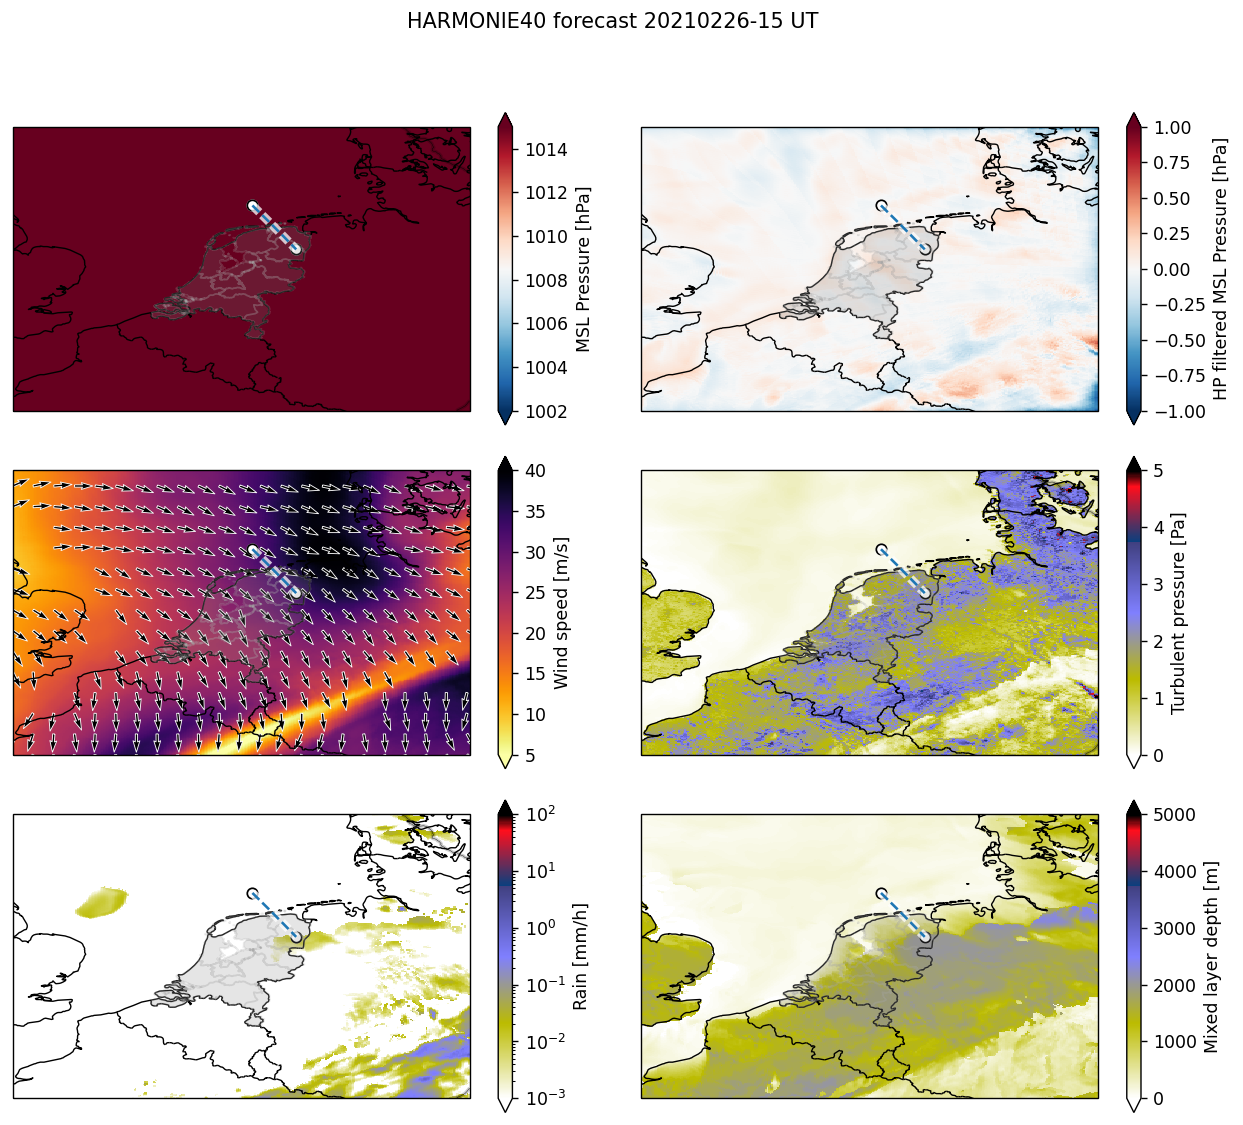

In [23]:
plot_meteo(my_atmos, ds)

In [24]:
path_params['end'] = dict(lat=df.loc[df.Site=='NL.EXL']['Latitude'].values[0],
                          lon=df.loc[df.Site=='NL.EXL'].Longitude.values[0])
# path_params['start'] = dict(lat=df.loc[df.Site=='Source'].Latitude.values[0],
#                             lon=df.loc[df.Site=='Source'].Longitude.values[0])
path_params['start'] = dict(lat=53.970, lon=5.806)
dr = 1.0e3
(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)

my_atmos.compute_azimuth_grid(ds, source=path_params['start'])
(cT, wa, wc, ce) = my_atmos.infrasound_propagation_conditions(t=ds.t,
                                                              u=ds.u,
                                                              v=ds.v,
                                                              azimuth=ds.azimuth)

c0 = ce.sel(hybrid=65)
cr = my_atmos.effective_sound_speed_ratio(ce, c0)

ds = xr.merge([cT.to_dataset(),
               wa.to_dataset(),
               wc.to_dataset(),
               ce.to_dataset(),
               cr.to_dataset(),
               ds],
               compat='override')

<ipython-input-25-47f18b03d330>:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-25-47f18b03d330>:120: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


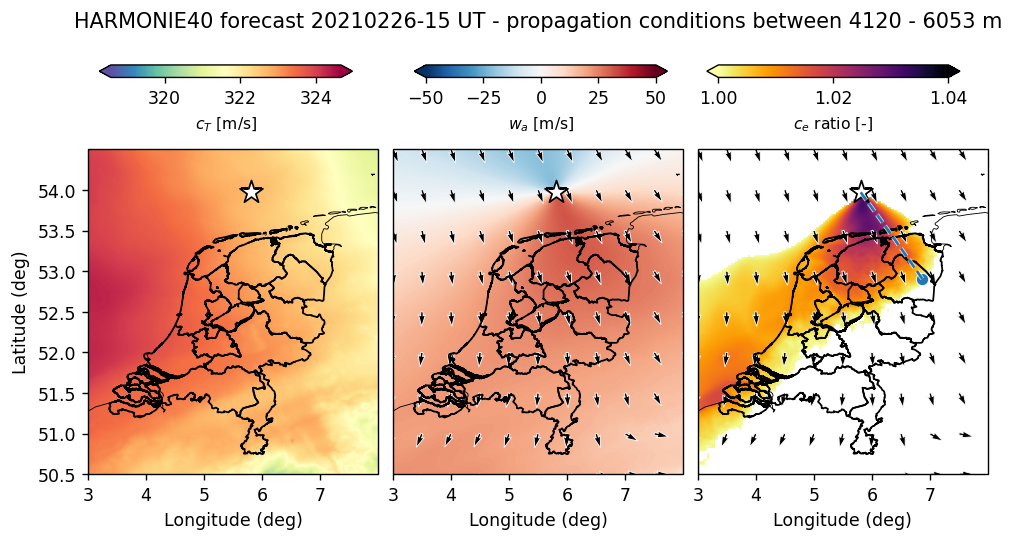

In [25]:
(t_fcst, model_str, fid_prefix) = plot_prefix(my_atmos, ds)

lev1 = 22
lev2 = 28
z1 = ds.hgt.sel(hybrid=lev1).mean().data
z2 = ds.hgt.sel(hybrid=lev2).mean().data

if lev1 == lev2:
    title_str = '{} - propagation conditions at {:.0f} m'.format(model_str, z1)
else:
    title_str = '{} - propagation conditions between {:.0f} - {:.0f} m'.format(model_str, z2, z1)


area_data = [ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()]
area_plot = [3, 8, 50.5, 54.5 ]

fig, ax = plt.subplots(1, 3, figsize=(9,5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.1, right=0.9, wspace=0.05, hspace=0.15)

# Plot adiabatic sound speed
xx = ds.cT.sel(hybrid=slice(lev1, lev2)).max(dim='hybrid')
im = ax[0].imshow(xx, cmap='Spectral_r',
                  origin='lower', extent=area_data, interpolation='bilinear', 
                  transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.11, 0.875, 0.225, 0.02])
cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
cbar.set_label(label='$c_{T}$ [m/s]', size=9)


# Plot wind and wind direction
u = ds.u.sel(hybrid=slice(lev1, lev2)).max(dim='hybrid')
v = ds.v.sel(hybrid=slice(lev1, lev2)).max(dim='hybrid')
w = np.sqrt(u**2+v**2)
# reinterpolate for wind arrows
_lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.5)
_lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.5)
ds.load()
u_ = u.interp(latitude=_lat, longitude=_lon)
v_ = v.interp(latitude=_lat, longitude=_lon)
w_ = np.sqrt(u_**2+v_**2)
u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_

xx = ds.wa.sel(hybrid=slice(lev1, lev2)).max(dim='hybrid')
im = ax[1].imshow(xx, cmap='RdBu_r',
                  origin='lower', extent=area_data, interpolation='bilinear', 
                  transform=ccrs.PlateCarree(), vmin=-50, vmax=50)
ax[1].quiver(_lon, _lat, u_.values, v_.values,
          scale=20,
          edgecolor='w',
          width=0.008,
          linewidth=0.5,
          transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.39, 0.875, 0.225, 0.02])
cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
cbar.set_label(label='$w_{a}$ [m/s]', size=9)

# Plot effective sound speed ratio
xx = ds.cr.sel(hybrid=slice(lev1, lev2)).max(dim='hybrid')
xx = xx.where(xx > 1.0)

im = ax[2].imshow(xx, cmap='inferno_r',
                  origin='lower', extent=area_data, interpolation='bilinear', 
                  transform=ccrs.PlateCarree(), vmin=1.0, vmax=1.04)
cb_ax = fig.add_axes([0.65, 0.875, 0.225, 0.02])
cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
cbar.set_label(label='$c_{e}$ ratio [-]', size=9)

ax[2].quiver(_lon, _lat, u_.values, v_.values,
          scale=20,
          edgecolor='w',
          width=0.008,
          linewidth=0.5,
          transform=ccrs.PlateCarree())


# General plotting aspect
lon_labels = np.arange(area_plot[0], area_plot[1], 1.0)
lat_labels = np.arange(area_plot[2], area_plot[3], 0.5)

for i in range (0,3):
    ax[i].set_aspect(aspect=1.4)
    ax[i].scatter(path_params['start']['lon']%360,
                  path_params['start']['lat'],
                  c='white', edgecolor='black', 
                  marker='*', s=192, transform=ccrs.PlateCarree())
    ax[i].set_extent(area_plot)

    #add Borders and so
    ax[i].coastlines(linewidth=.5, color='black')
    #ax.add_feature(BORDERS, linewidth=0.5, color='black')
    #add Dutch provinces
    ax[i].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                     edgecolor='black', linestyle='solid', facecolor='none')

    #gl = ax[i].gridlines(linestyle=":", dms=True)

    #ax[i].set_yticks(lat_labels)
    ax[i].set_xticks(lon_labels)
    ax[i].set_xlabel('Longitude (deg)')
    ax[i].set_ylabel('')

# gl.xlocator = mticker.FixedLocator(lon_labels)
# gl.ylocator = mticker.FixedLocator(lat_labels)
# gl.top_labels = gl.right_labels = False

ax[2].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
           path_effects=[pe.Stroke(linewidth=2.5, foreground='w', alpha=0.75), pe.Normal()])
ax[2].scatter(path_params['end']['lon']%360,
              path_params['end']['lat'],
              c='C0', edgecolors='white', linewidth=0.5, marker='o', s=50,
              transform=ccrs.PlateCarree())

ax[0].set_yticks(lat_labels)
ax[0].set_ylabel('Latitude (deg)')

fig.suptitle(title_str)
fig.tight_layout()

fid_gcp = 'effsnd_map.pdf'
fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

plt.show()